# Otimização de hiperparâmetros da Rede Neural usando o Optuna

## Introdução:

A partir do arquivo [Introdução](Introdução.ipynb) , foi possível identificar parâmetros e características das Features e dos Targets. A partir disso, iremos treinar uma Rede Neural MLP (Multi Layer Perceptron), com o uso do Pytorch, com diversas arquiteturas distintas, através do Optuna, para identificar os melhores hiperparâmetros para a previsão dos nossos Targets.

As Redes Neurais funcionam a partir de Camadas de Neurônios, que recebem uma informação com um determinado peso e processa essa dado através de uma função de ativação e um viés, resultando num output que é passado para outro neurônio conectado ou final. As Redes Neurais possuem numeros variáveis de camadas e neurônios em cada camada. Dessa forma, sendo hiperparâmetros da arquitetura da nossa rede.

Para isso, iremos usar o Optuna, que consegue calcular a métricas de diversas arquiteturas de Redes Neurais. Assim, escolhendo os hiperparâmetros que funcionam melhor para a predição dos nossos targets.

## Importando os módulos necessários

In [87]:
import os
import tempfile
import pandas as pd

import optuna
#from optuna.artifacts import download_artifact
#from optuna.artifacts import FileSystemArtifactStore
#from optuna.artifacts import upload_artifact
#from optuna.storages import RetryFailedTrialCallback
import optuna.visualization as vis

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
from torch.utils.data import TensorDataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MaxAbsScaler
from sklearn.metrics import mean_squared_error

### Definindo as constantes do problema:

In [5]:
DEVICE = torch.device("cpu") # Sem GPU
SEMENTE_ALEATORIA = 1249

NUM_TARGETS = 2
NUM_EPOCAS = 10

TAMANHO_TESTE = 0.1
TAMANHO_VALIDACAO = 0.1

PATIENCE = 5
MIN_DELTA = 0.01 # Alteração mínima na perda para que se qualifique como melhora

## Pré-processamento:

Carregando o dataset e coletando as colunas que serão usadas como targets e como features:

In [57]:
TARGET = ["Storage_Efficiency_Percentage",
         "GHG_Emission_Reduction_tCO2e"]
FEATURES = [
    "Type_of_Renewable_Energy",
    "Grid_Integration_Level",
    "Funding_Sources",
    "Installed_Capacity_MW",
    "Energy_Production_MWh",
    "Energy_Consumption_MWh",
    "Initial_Investment_USD",
    "Air_Pollution_Reduction_Index",
]

In [74]:
df_energia = pd.read_csv('energy_dataset_.csv')
df_energia = df_energia.reindex(FEATURES + TARGET, axis=1)
df_energia = df_energia.dropna()
df_energia

,Type_of_Renewable_Energy,Grid_Integration_Level,Funding_Sources,Installed_Capacity_MW,Energy_Production_MWh,Energy_Consumption_MWh,Initial_Investment_USD,Air_Pollution_Reduction_Index,Storage_Efficiency_Percentage,GHG_Emission_Reduction_tCO2e
0,4,4,1,93.423205,103853.2206,248708.4892,4.732248e+08,81.742461,89.887562,6663.816572
1,4,4,2,590.468942,190223.0649,166104.1642,1.670697e+08,78.139042,84.403343,30656.049820
2,1,2,2,625.951142,266023.4824,424114.6308,8.463610e+07,8.461296,60.498249,1749.613759
3,1,3,2,779.998728,487039.5296,308337.7316,3.967690e+08,8.402441,86.897861,43233.237820
4,3,2,1,242.106837,482815.0856,360437.7705,3.574413e+07,28.822867,70.949351,14858.662760
...,...,...,...,...,...,...,...,...,...,...
14995,3,4,2,745.032555,280007.5738,230544.8268,3.484136e+08,78.923200,90.791405,25234.911810
14996,1,4,3,15.187023,377340.5803,358547.3589,2.560179e+08,54.982974,78.252040,15762.519790
14997,3,1,2,877.539059,480497.3920,214441.6719,1.300112e+08,43.915897,58.282928,44597.809410
14998,7,2,2,551.264716,436383.1694,137043.8713,3.334831e+08,4.877145,73.573666,34363.858000


Dividindo os dados em treino, validação e teste, permitindo que a rede neural se ajuste aos dados de treino e seja otimizada para os dados de validação, evitando o *overfitting*:

In [75]:
indices = df_energia.index
indices_treino_val, indices_teste = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino_val = df_energia.loc[indices_treino_val]
df_teste = df_energia.loc[indices_teste]

X_teste = df_teste.reindex(FEATURES, axis=1).values
y_teste = df_teste.reindex(TARGET, axis=1).values

In [76]:
indices = df_treino_val.index
indices_treino, indices_val = train_test_split(
    indices, test_size=TAMANHO_TESTE, random_state=SEMENTE_ALEATORIA
)

df_treino = df_energia.loc[indices_treino]
df_val = df_energia.loc[indices_val]

X_treino = df_treino.reindex(FEATURES, axis=1).values
y_treino = df_treino.reindex(TARGET, axis=1).values

X_val = df_val.reindex(FEATURES, axis=1).values
y_val = df_val.reindex(TARGET, axis=1).values

Fazendo uma normalização por Máximo Absoluto, ajustando aos dados de treino e transformando aos demais dados:


In [83]:
scaler = MaxAbsScaler()

# Para os valores de X

scaler.fit(X_treino)

X_treino = scaler.transform(X_treino)
X_teste  = scaler.transform(X_teste)
X_val = scaler.transform(X_val)

# Para os valores de y:

# Organizando em 2 dimensões para o PyTorch
y_treino = y_treino.reshape(-1,2)
y_teste  = y_teste.reshape(-1,2)
y_val = y_val.reshape(-1,2)

# Aplicando a normalização
scaler.fit(y_treino) 

y_treino = scaler.transform(y_treino)
y_teste  = scaler.transform(y_teste)
y_val = scaler.transform(y_val)

Convertendo os dados para Tensores, uma estrutura especial utilizada no módulo `Pytorch`:

In [84]:
X_treino = torch.tensor(X_treino, dtype=torch.float32)
y_treino = torch.tensor(y_treino, dtype=torch.float32)

X_val = torch.tensor(X_val, dtype=torch.float32)
y_val = torch.tensor(y_val, dtype=torch.float32)

X_teste = torch.tensor(X_teste, dtype=torch.float32)
y_teste = torch.tensor(y_teste, dtype=torch.float32)

EXPLICAR OQ É TENSORDATASET E PQ USAR

In [89]:
treino_dataset = TensorDataset(X_treino, y_treino)
validacao_dataset = TensorDataset(X_val, y_val)
teste_dataset = TensorDataset(X_teste, y_teste)

## Otimização com Optuna:

### Definindo o modelo:

In [9]:
def define_model(trial):
    n_camadas = trial.suggest_int("n_camadas", 2, 5)
    camadas = []

    in_features = len(FEATURES)
    for i in range(n_camadas):
        out_features = trial.suggest_int(f"n_neuronios{i}", 2, 5)
        camadas.append(nn.Linear(in_features, out_features))
        camadas.append(nn.ReLU())
        in_features = out_features

    camadas.append(nn.Linear(in_features, NUM_TARGETS))
    

    return nn.Sequential(*camadas)

### Criando a função objetivo:

In [90]:
def objective(trial):
    optuna.seed = SEMENTE_ALEATORIA    
    model = define_model(trial).to(DEVICE)    

    nome_otimizador = trial.suggest_categorical("otimizador", ["Adam", "RMSprop", "SGD" ])
    lr = trial.suggest_float("lr", 1e-4, 1e-1, log=True)
    otimizador = getattr(optim, nome_otimizador)(model.parameters(), lr=lr)

    batch_size = trial.suggest_categorical("batch_size", [32, 64, 128])
    treino_loader = DataLoader(treino_dataset, batch_size=batch_size, shuffle=True)
    validacao_loader = DataLoader(validacao_dataset, batch_size=batch_size, shuffle=False)

    melhor_loss = float("inf")

    print(f"Trial {trial.number}")

    for epoch in range(EPOCHS):        
        
        model.train() #modo de treinamento

        for batch_data, batch_target in treino_loader:
            batch_data, batch_target = batch_data.to(DEVICE), batch_target.to(DEVICE)
            
            #Foward pass
            output = model(batch_data)

            #Zero Grad
            otimizador.zero_grad()
            
            #Calculo da perda
            loss = F.mse_loss(output, batch_target)

            #Backpropagation
            loss.backward()
            
            #Atualiza os parâmetros
            otimizador.step()

        # validação
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for batch_data_val, batch_target_val in validacao_loader: 
                batch_data_val, batch_target_val = batch_data_val.to(DEVICE), batch_target_val.to(DEVICE)
                output_val = model(batch_data_val)
                val_loss_epoch += F.mse_loss(output_val, batch_target_val, reduction='sum').item() # Soma das perdas


        val_loss /= len(validacao_loader.dataset)
        trial.report(-val_loss, epoch)  # negativo, pois queremos minimizar a loss

        # early stopping
        if val_loss < (melhor_loss - MIN_DELTA):
            melhor_loss = val_loss
            contador_tol = 0

        else:
            contador_tol += 1
            if contador_tol >= PATIENCE:
                print(f"Parada Antecipada (Early Stopping) na época {epoch}.")
                break


        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()

    print(f"[Trial {trial.number} Final] Melhor Val Loss: {melhor_loss:.4f}")
        
    return -melhor_loss  # objetivo: maximizar valor → minimizar loss

### Realizando o Optuna no HPC:

In [4]:
NOME_DO_ESTUDO = "Hiperparametros_RN"

study = optuna.create_study(
    direction="maximize", # analisar se o objetivo é maximizar ou minimizar
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
    load_if_exists=True
)

[I 2025-06-07 21:57:14,906] Using an existing study with name 'hiperparametros_RN' instead of creating a new one.


In [ ]:
study.optimize(objective, n_trials=100)

### Obtendo os melhores parâmetros testados pelo Optuna

In [13]:
melhor_trial = study.best_trial

print(f"Número do melhor trial: {melhor_trial.number}")
print("Melhor valor:", study.best_value)
print("Melhores hiperparâmetros:")

for key, value in study.best_params.items():
    print(f"  {key}: {value}")

Número do melhor trial: 34
Melhor valor: -0.10446994409610785
Melhores hiperparâmetros:
  n_camadas: 3
  n_neuronios0: 3
  n_neuronios1: 4
  n_neuronios2: 4
  otimizador: RMSprop
  lr: 0.00012507319573898723


### Plotando alguns dados da otimização de hiperparâmetros disponíveis pelo próprio módulo do Optuna

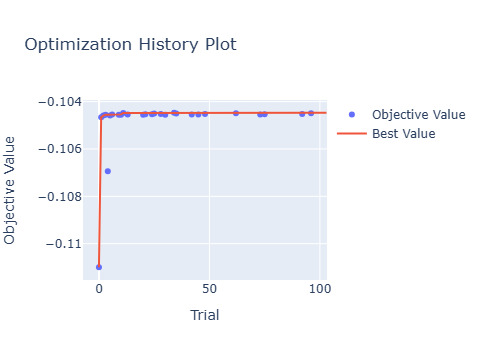

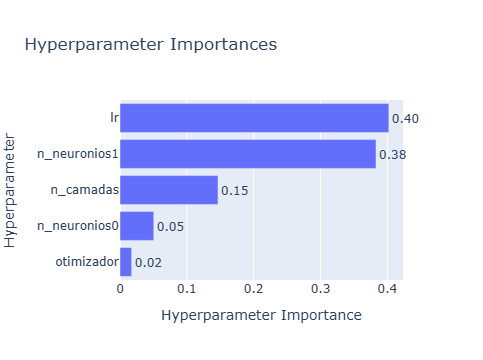

In [60]:
# Histórico da otimização (melhor valor a cada trial)
vis.plot_optimization_history(study).show()

# Importância de cada hiperparâmetro
vis.plot_param_importances(study).show()

## Testando o melhor modelo:

### Carregando o estudo salvo:

In [6]:
from optuna import load_study

objeto_de_estudo_carregado = load_study(
    study_name=NOME_DO_ESTUDO,
    storage=f"sqlite:///{NOME_DO_ESTUDO}.db",
)

df_optuna = objeto_de_estudo_carregado.trials_dataframe()

df_optuna

,number,value,datetime_start,datetime_complete,duration,params_lr,params_n_camadas,params_n_neuronios0,params_n_neuronios1,params_n_neuronios2,params_n_neuronios3,params_n_neuronios4,params_otimizador,state
0,0,-0.110994,2025-06-07 17:28:03.088695,2025-06-07 17:28:58.528855,0 days 00:00:55.440160,0.000187,5,3,2,5.0,3.0,5.0,SGD,COMPLETE
1,1,-0.104662,2025-06-07 17:28:58.576767,2025-06-07 17:30:09.316574,0 days 00:01:10.739807,0.001763,3,3,3,5.0,NaN,NaN,RMSprop,COMPLETE
2,2,-0.104590,2025-06-07 17:30:09.384863,2025-06-07 17:31:36.922161,0 days 00:01:27.537298,0.000128,4,3,2,2.0,5.0,NaN,Adam,COMPLETE
3,3,-0.104551,2025-06-07 17:31:37.043876,2025-06-07 17:32:52.743137,0 days 00:01:15.699261,0.000201,4,3,5,5.0,3.0,NaN,Adam,COMPLETE
4,4,-0.106939,2025-06-07 17:32:52.786328,2025-06-07 17:34:13.012909,0 days 00:01:20.226581,0.021584,4,5,2,3.0,4.0,NaN,RMSprop,COMPLETE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99,99,-0.105136,2025-06-07 18:10:12.839384,2025-06-07 18:10:23.750144,0 days 00:00:10.910760,0.000488,3,4,5,3.0,NaN,NaN,Adam,PRUNED
100,100,-0.104565,2025-06-07 18:11:45.687781,2025-06-07 18:12:09.154438,0 days 00:00:23.466657,0.000292,3,4,2,4.0,NaN,NaN,Adam,PRUNED
101,101,-0.104752,2025-06-07 18:12:09.225073,2025-06-07 18:12:20.990742,0 days 00:00:11.765669,0.000968,3,4,5,4.0,NaN,NaN,Adam,PRUNED
102,102,-0.104675,2025-06-07 18:12:21.036821,2025-06-07 18:12:29.841156,0 days 00:00:08.804335,0.001183,3,2,5,4.0,NaN,NaN,SGD,PRUNED


In [66]:
modelo = define_model(melhor_trial)
modelo.eval()

Sequential(
  (0): Linear(in_features=8, out_features=3, bias=True)
  (1): ReLU()
  (2): Linear(in_features=3, out_features=4, bias=True)
  (3): ReLU()
  (4): Linear(in_features=4, out_features=4, bias=True)
  (5): ReLU()
  (6): Linear(in_features=4, out_features=2, bias=True)
)

In [67]:
with torch.no_grad():
    y_true = scaler.inverse_transform(y_teste)

    y_pred = modelo(X_teste)
    y_pred = scaler.inverse_transform(y_pred)

    RMSE_eficiencia = mean_squared_error(y_pred[:, 0], y_true[:, 0]) ** (1/2)
    RMSE_reducao_co2 = mean_squared_error(y_pred[:, 1], y_true[:, 1]) ** (1/2)

    #RMSE = mean_squared_error(y_true, y_pred) ** (1/2)

ValueError: Found input variables with inconsistent numbers of samples: [1500, 3000]

In [71]:
len(y_pred[:,1])

1500

In [73]:
len(y_pred)

1500

In [70]:
len(y_true[:,0])

3000

## Conclusões:

Com base na otimização dos hiperparâmetros da Rede Neural, modificando o otimizador usado, número de camadas e neurônios em cada camada. Obteve-se um conjunto de parâmetros que minimizava a perda do da nossa rede neural.

## Referências:


[1] https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_simple.py

[2] https://github.com/optuna/optuna-examples/blob/main/pytorch/pytorch_checkpoint.py